## Imports & Tested Version

In [5]:
import sys, scprep, magic, scanpy, sklearn
import warnings; warnings.filterwarnings('ignore')
sys.path.append('..') # replace with location of AAnet from https://github.com/KrishnaswamyLab/AAnet
from AAnet_torch import * # use torch implementation
import torch; from torch import optim
import numpy as np
import matplotlib; import matplotlib.pyplot as plt
from sklearn import decomposition

In [6]:
print ('Python', sys.version)
print ('scprep', scprep.__version__)
print ('magic', magic.__version__)
print ('scanpy', magic.__version__)
print ('sklearn', sklearn.__version__)
print ('torch', torch.__version__)
print ('numpy', np.__version__)
print ('matplotlib', matplotlib.__version__)

Python 3.8.18 | packaged by conda-forge | (default, Oct 10 2023, 15:44:36) 
[GCC 12.3.0]
scprep 1.2.3
magic 3.0.0
scanpy 3.0.0
sklearn 1.3.2
torch 2.4.0+cu121
numpy 1.22.4
matplotlib 3.7.3


## AAnet

### Global Setup

In [7]:
np.random.seed(0)
N_ARCHETYPES = 4
azim = -30 # for visualization
tissue = 'Pancreatic beta cells'
color = 'maroon'

In [25]:
# Read in example dataset
adata_beta_hfd = scanpy.read_h5ad('data/beta_cells_hfd.h5ad')

In [26]:
adata_beta_hfd

AnnData object with n_obs × n_vars = 3887 × 16483
    obs: 'sample'
    var: 'human_name', 'ids'

### The input into the AAnet model are the principal component embeddings. This way, we can decode principal component embeddings of the archetypes, then inverse transform the archetypes back to the gene space to get their expression measurements.We first run MAGIC, then PCA, to denoise the data and maintain the invertibility of the embedding.

In [27]:
hfd_magic_op = magic.MAGIC(random_state=42, t=10)
hfd_magic = hfd_magic_op.fit_transform(adata_beta_hfd.to_df())

Calculating MAGIC...
  Running MAGIC on 3887 cells and 16483 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.44 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.02 seconds.
    Calculating affinities...
    Calculated affinities in 2.02 seconds.
  Calculated graph and diffusion operator in 6.58 seconds.
  Running MAGIC with `solver='exact'` on 16483-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 2.05 seconds.
Calculated MAGIC in 8.75 seconds.


In [28]:
hfd_pc_op = decomposition.PCA(n_components=20, random_state=42)
hfd_magic_pc = hfd_pc_op.fit_transform(hfd_magic)

# Normalize for AAnet model
hfd_magic_pc_norm = hfd_magic_pc / np.std(hfd_magic_pc[:, 0])

### Get diffusion extrema

#### Density subsampling may be useful to offset differences in density for diffusion extrema prediction. Consider testing diffusion extrema with and without density subsampling.

#### Without subsampling

In [36]:
extrema = torch.Tensor(utils.get_laplacian_extrema(hfd_magic_pc_norm, n_extrema=N_ARCHETYPES, subsample=False))
extrema = torch.Tensor(hfd_magic_pc_norm[extrema.numpy().astype(int)])

<Axes3D: title={'center': 'Pancreatic beta cells'}>

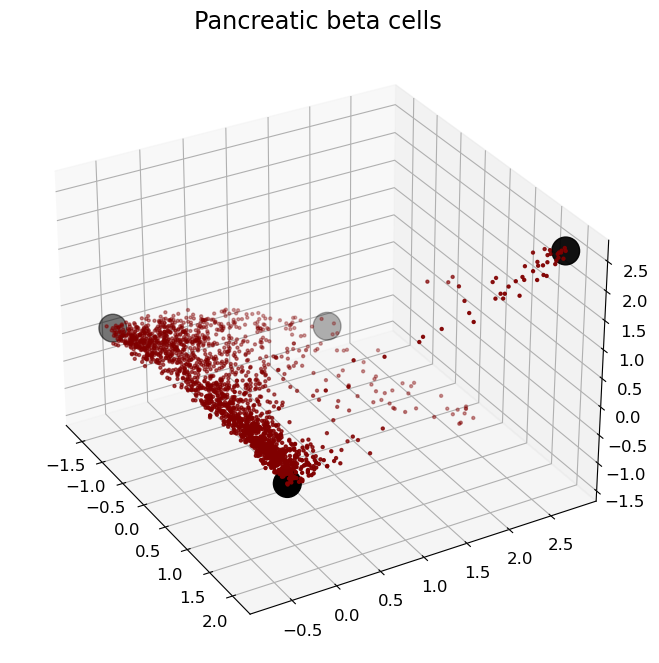

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

scprep.plot.scatter3d(X_subsample, c=color,
                          ylabel=None, zorder=1,
                          title=tissue, colorbar=False, ax=ax)

scprep.plot.scatter3d(extrema.cpu().detach().numpy(), ax=ax, azim=azim,
                             c='black', s=400, figsize=(10,10), colorbar=False)

#### With subsampling

In [48]:
distances, _ = sklearn.neighbors.NearestNeighbors(n_neighbors=2000).fit(hfd_magic_pc_norm).kneighbors()
distances = distances.max(axis=1)
p = distances / distances.sum()
X_subsample = scprep.select.select_rows(hfd_magic_pc_norm, idx=np.random.choice(hfd_magic_pc_norm.shape[0],
                                                                int(hfd_magic_pc_norm.shape[0]/2), p=p, replace=False))

extrema = torch.Tensor(utils.get_laplacian_extrema(X_subsample, n_extrema=N_ARCHETYPES, subsample=False))
extrema = torch.Tensor(X_subsample[extrema.numpy().astype(int)])

<Axes3D: title={'center': 'Pancreatic beta cells'}>

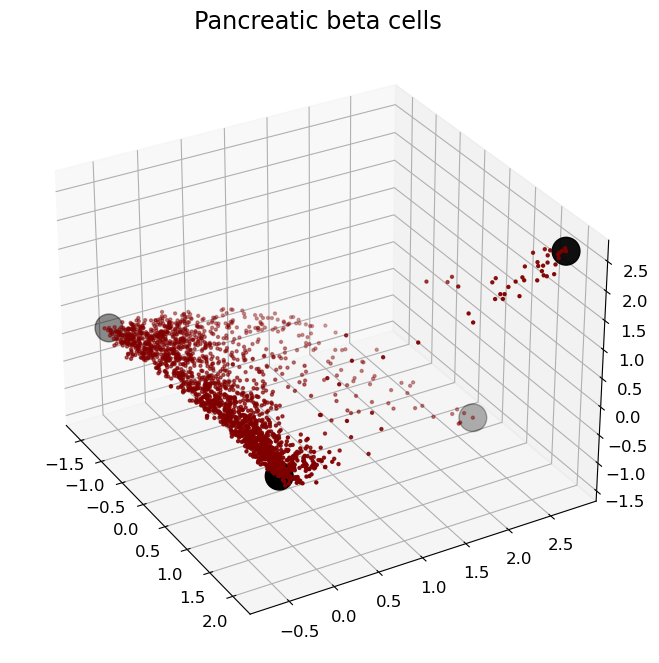

In [49]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

scprep.plot.scatter3d(X_subsample, c=color,
                          ylabel=None, zorder=1,
                          title=tissue, colorbar=False, ax=ax)

scprep.plot.scatter3d(extrema.cpu().detach().numpy(), ax=ax, azim=azim,
                             c='black', s=400, figsize=(10,10), colorbar=False)

### Run AAnet
#### AAnet performs much better with diffusion extrema initialization (`gamma_extrema` > 0.0)

In [50]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES,
                             input_shape=hfd_magic_pc_norm.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [51]:
data_loader = torch.utils.data.DataLoader(hfd_magic_pc_norm, batch_size=256, shuffle=True, num_workers=2)

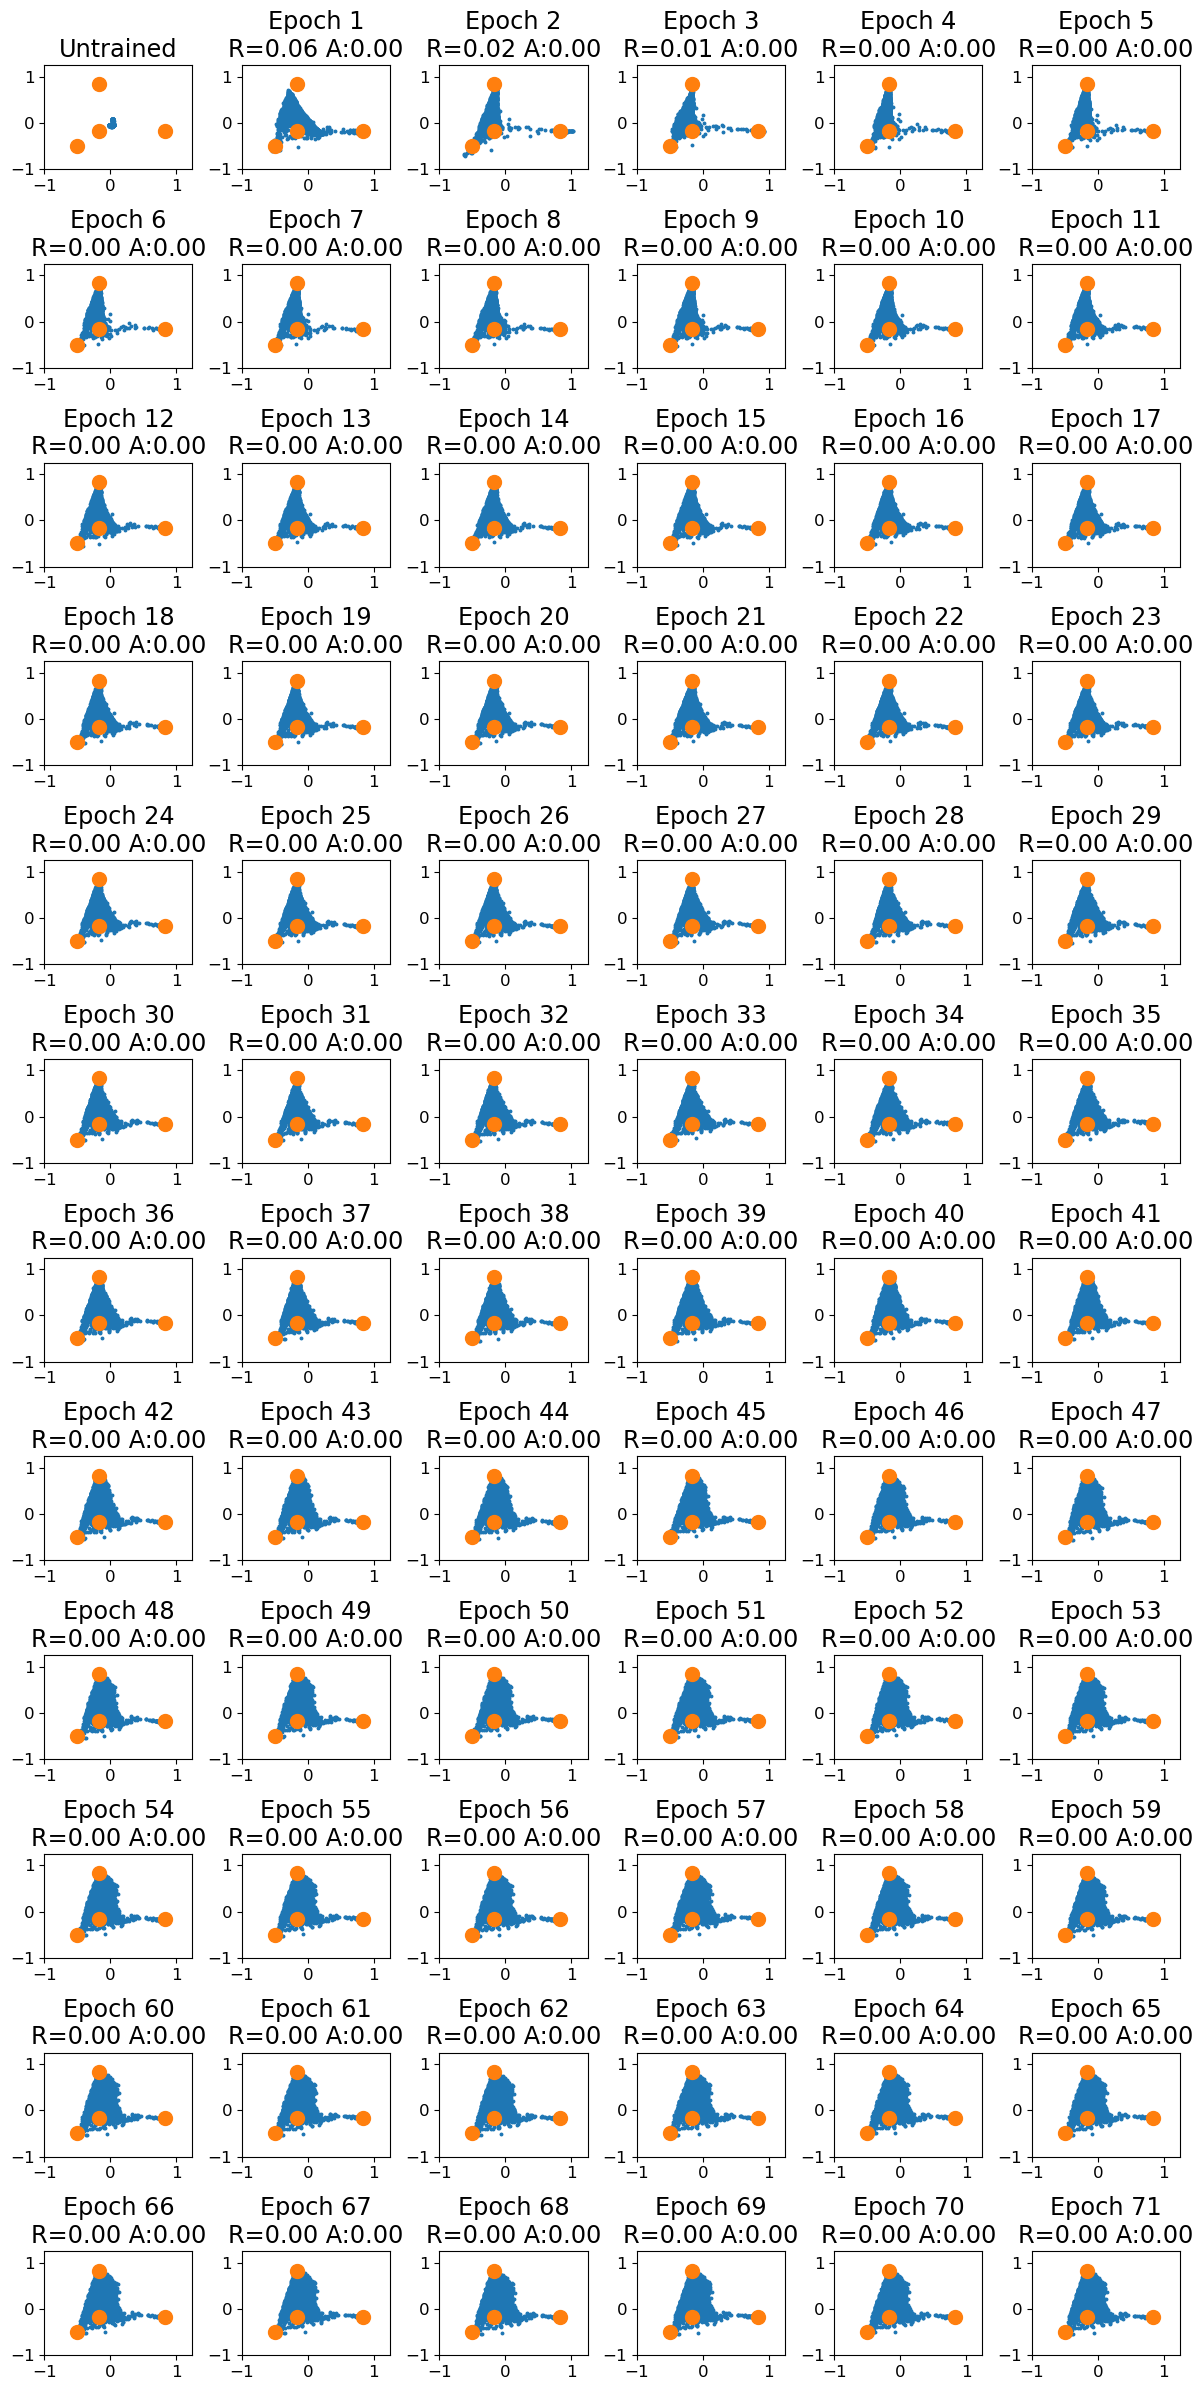

In [52]:
n_row = 12
n_col = 6
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        r_loss = a_loss = 0

        title='Untrained'
    else:
        # gamma_extrema parameter weights how informative graph-based extrema are to model
        loss, r_loss, a_loss=utils.train_epoch(model, data_loader, optimizer, epoch=i, gamma_extrema=1.0)
        title='Epoch {}\nR={:.2f} A:{:.2f}'.format(i, r_loss, a_loss)

    archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm))

    scprep.plot.scatter2d(archetypal_embedding.detach().cpu().numpy(), title=title, ax=ax)
    scprep.plot.scatter2d(model.get_n_simplex(model.n_archetypes).cpu().numpy(), ax=ax)
    ax.set_xlim(-1, 1.25)
    ax.set_ylim(-1, 1.25)

fig.tight_layout()

#### AAnet training results in the following useful outputs:

`barycentric_archetypal_embedding: n_obs x n_ats`: Archetypal affinity for each cell.  
`pc_ats: n_ats x n_pcs`: Embedding for each archetype based on input embedding (here we used PCs).   
`data_ats: n_ats x n_genes`: Ambient space measurement for each archetype by inverse transforming from PC space.

In [53]:
archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
pc_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()
data_ats = ((pc_ats * np.std(hfd_magic_pc[:,0])) @ hfd_pc_op.components_)

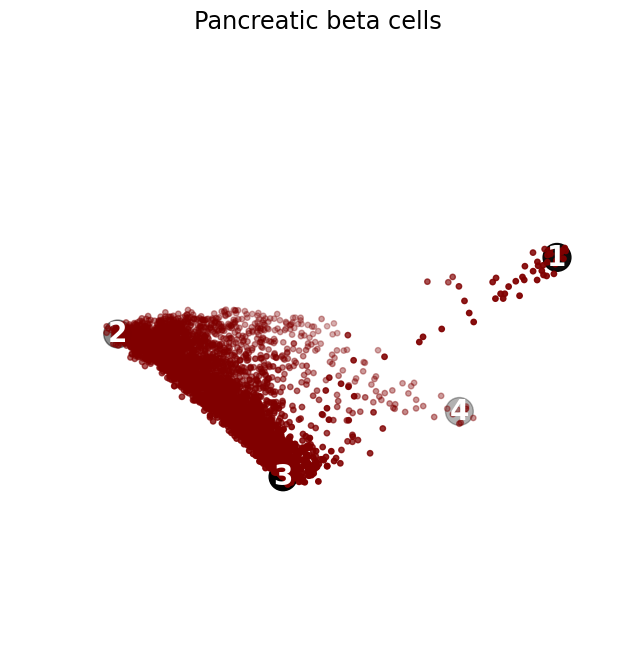

In [54]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

scprep.plot.scatter3d(hfd_magic_pc_norm, c=color,
                          ylabel=None, zorder=1, s=15,
                          title=tissue, colorbar=False, ax=ax)

scprep.plot.scatter3d(pc_ats, ax=ax, c='black', s=400, figsize=(10,10), colorbar=False,azim=azim,)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.axis('off')
for t,coord in enumerate(pc_ats):
        ax.text(coord[0], coord[1], coord[2], s=t+1, horizontalalignment='center',
                        verticalalignment='center', fontdict={'color': 'white','size':20,'weight':'bold'}, zorder=4)

## Save model and outputs

In [55]:
torch.save(model.state_dict(), f'results/Beta_cells_model_state_dict')

In [56]:
np.savez(f'results/Beta_cell_AAnet_results.npz', data_ats=data_ats, pc_ats=pc_ats, latent_coords=barycentric_archetypal_embedding)